##### Copyright 2018 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Eight Schools の問題

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/probability/examples/Eight_Schools"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/probability/examples/Eight_Schools.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/probability/examples/Eight_Schools.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png"> GitHub でソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/probability/examples/Eight_Schools.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

Eight Schools の問題（[Rubin 1981](https://www.jstor.org/stable/1164617)）は、8 つの高校で同時に実施された SAT 指導プログラムの有効性を考察する問題です。交換可能なグループ間で情報を共有する階層モデルの有用性を説明する古典的な問題（[Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/), [Stan](https://github.com/stan-dev/rstan/wiki/RStan-Getting-Started)）になっています。

以下の実装は Edward 1.0 の[チュートリアル](https://github.com/blei-lab/edward/blob/master/notebooks/eight_schools.ipynb)を調整し直したものです。

# インポート

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
import warnings

tf.enable_v2_behavior()

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

# データ

『Bayesian Data Analysis』第 5.5 項（Gelman et al. 2013）の抄訳:

> *8 つの高校で実施された SAT-V（Scholastic Aptitude Test-Verbal）特別指導プログラムの効果を分析するために、Educational Testing Service の調査が実施されました。各調査の結果変数は、SAT-V の特別実施のスコアでした。これは、Educational Testing Service が運営し、大学が入学決定を下す際に使用する標準化された多肢選択式テストです。スコアは 200 点から 800 点の間で変動し、平均は約 500 点、標準偏差は約 100 点です。SA​​T 試験は、特に試験の成績を上げるための短期的な取り組みを評価するものではなく、長期にわたる学習で得た知識と能力の開発を反映するように設計されています。それにもかかわらず、この調査の対象となった 8 つの高校では、その短期指導プログラムが SAT のスコアの引き上げに非常に役立つと考えました。また、8 つのプログラムのいずれも、他のプログラムよりも効果的であったり、いくつかのプログラムの効果の類似性が他のプログラムのものよりも高かったりすることを予め信じる理由はありませんでした。*

8 つの各高校（$J = 8$）について、推定処置効果 $y_j$ と効果推定の標準誤差 $\sigma_j$ があります。調査の処置効果は、PSAT-M と PSAT-V スコアを制御変数として使用し、処置グループの線形回帰によって取得されました。いずれの高校も類似性がある、またはいずれかの指導プログラムの効果がより高いという考えが前もってなかったため、処置効果を[交換可能](https://en.wikipedia.org/wiki/Exchangeable_random_variables)と捉えることができます。

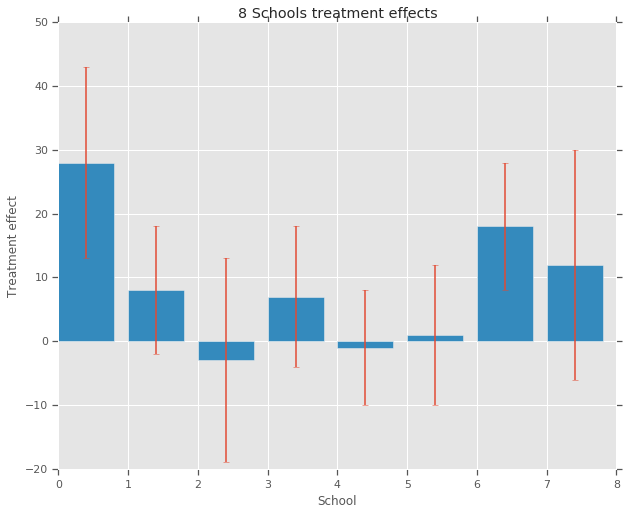

In [ ]:
num_schools = 8  # number of schools
treatment_effects = np.array(
    [28, 8, -3, 7, -1, 1, 18, 12], dtype=np.float32)  # treatment effects
treatment_stddevs = np.array(
    [15, 10, 16, 11, 9, 11, 10, 18], dtype=np.float32)  # treatment SE

fig, ax = plt.subplots()
plt.bar(range(num_schools), treatment_effects, yerr=treatment_stddevs)
plt.title("8 Schools treatment effects")
plt.xlabel("School")
plt.ylabel("Treatment effect")
fig.set_size_inches(10, 8)
plt.show()

# モデル

データを取得するために、階層正規モデルを使用します。これは次の生成プロセスに従います。

$$ \begin{align*} \mu &amp;\sim \text{Normal}(\text{loc}{=}0,\ \text{scale}{=}10) \ \log\tau &amp;\sim \text{Normal}(\text{loc}{=}5,\ \text{scale}{=}1) \ \text{for } &amp; i=1\ldots 8:\ &amp; \theta_i \sim \text{Normal}\left(\text{loc}{=}\mu,\ \text{scale}{=}\tau \right) \ &amp; y_i \sim \text{Normal}\left(\text{loc}{=}\theta_i,\ \text{scale}{=}\sigma_i \right) \end{align*} $$

上記の $\mu$ は、事前の平均処置効果を表し、$\tau$ は、高校間でどれくらいのバリアンスがあるかを制御します。$y_i$ と $\sigma_i$ は観測済みです。$\tau \rightarrow \infty$ である場合、モデルは非プーリングモデルに近づきます。つまり、各高校の処理効果の推定は、より独立した推定になれるということです。$\tau \rightarrow 0$ である場合、モデルは完全なプーリングモデルに近づきます。つまり、すべての高校の処置効果は、集団平均 $\mu$ により近づきます。標準偏差が正にならないように、対数正規分布から $\tau$ をドローします（正規分布から $log(\tau)$ をドローすることに相当します）。

「[Diagnosing Biased Inference with Divergences](http://mc-stan.org/users/documentation/case-studies/divergences_and_bias.html)」に従って、上記のモデルを同等の非中心モデルに変換します。

$$ \begin{align*} \mu &amp;\sim \text{Normal}(\text{loc}{=}0,\ \text{scale}{=}10) \ \log\tau &amp;\sim \text{Normal}(\text{loc}{=}5,\ \text{scale}{=}1) \ \text{for } &amp; i=1\ldots 8:\ &amp; \theta_i' \sim \text{Normal}\left(\text{loc}{=}0,\ \text{scale}{=}1 \right) \ &amp; \theta_i = \mu + \tau \theta_i' \ &amp; y_i \sim \text{Normal}\left(\text{loc}{=}\theta_i,\ \text{scale}{=}\sigma_i \right) \end{align*} $$

このモデルを [JointDistributionSequential](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/JointDistributionSequential) インスタンスとして具体化します。

In [ ]:
model = tfd.JointDistributionSequential([
  tfd.Normal(loc=0., scale=10., name="avg_effect"),  # `mu` above
  tfd.Normal(loc=5., scale=1., name="avg_stddev"),  # `log(tau)` above
  tfd.Independent(tfd.Normal(loc=tf.zeros(num_schools),
                             scale=tf.ones(num_schools),
                             name="school_effects_standard"),  # `theta_prime` 
                  reinterpreted_batch_ndims=1),
  lambda school_effects_standard, avg_stddev, avg_effect: (
      tfd.Independent(tfd.Normal(loc=(avg_effect[..., tf.newaxis] +
                                      tf.exp(avg_stddev[..., tf.newaxis]) *
                                      school_effects_standard),  # `theta` above
                                 scale=treatment_stddevs),
                      name="treatment_effects",  # `y` above
                      reinterpreted_batch_ndims=1))
])

def target_log_prob_fn(avg_effect, avg_stddev, school_effects_standard):
  """Unnormalized target density as a function of states."""
  return model.log_prob((
      avg_effect, avg_stddev, school_effects_standard, treatment_effects))

# ベイズ推論

特定のデータで、ハミルトニアンモンテカルロ（HMC）を実行して、モデルのパラメータで事後確率分布を計算します。

In [ ]:
num_results = 5000
num_burnin_steps = 3000

# Improve performance by tracing the sampler using `tf.function`
# and compiling it using XLA.
@tf.function(autograph=False, jit_compile=True)
def do_sampling():
  return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[
          tf.zeros([], name='init_avg_effect'),
          tf.zeros([], name='init_avg_stddev'),
          tf.ones([num_schools], name='init_school_effects_standard'),
      ],
      kernel=tfp.mcmc.HamiltonianMonteCarlo(
          target_log_prob_fn=target_log_prob_fn,
          step_size=0.4,
          num_leapfrog_steps=3))

states, kernel_results = do_sampling()

avg_effect, avg_stddev, school_effects_standard = states

school_effects_samples = (
    avg_effect[:, np.newaxis] +
    np.exp(avg_stddev)[:, np.newaxis] * school_effects_standard)

num_accepted = np.sum(kernel_results.is_accepted)
print('Acceptance rate: {}'.format(num_accepted / num_results))

Acceptance rate: 0.5974


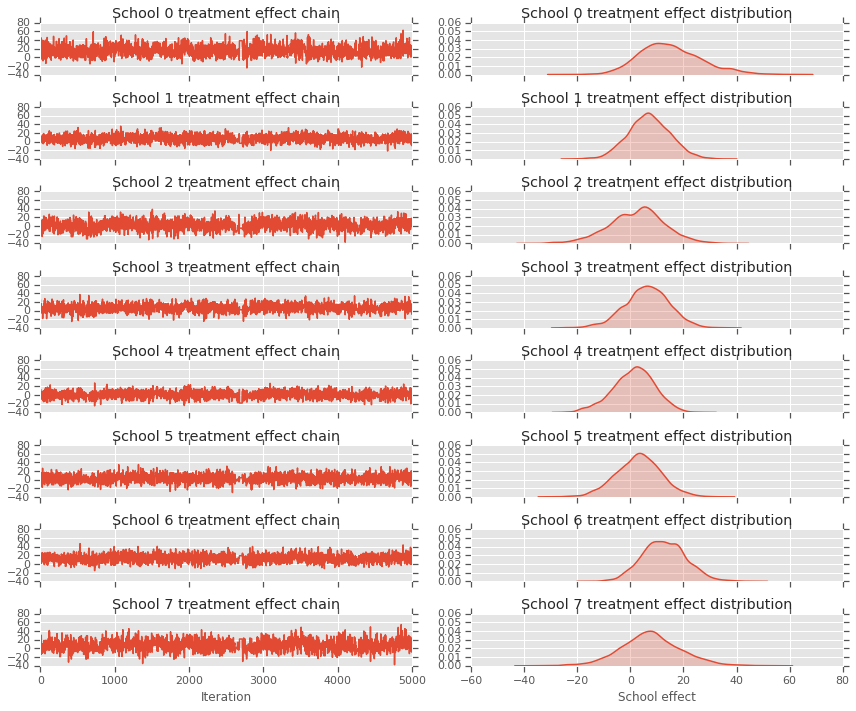

In [ ]:
fig, axes = plt.subplots(8, 2, sharex='col', sharey='col')
fig.set_size_inches(12, 10)
for i in range(num_schools):
  axes[i][0].plot(school_effects_samples[:,i].numpy())
  axes[i][0].title.set_text("School {} treatment effect chain".format(i))
  sns.kdeplot(school_effects_samples[:,i].numpy(), ax=axes[i][1], shade=True)
  axes[i][1].title.set_text("School {} treatment effect distribution".format(i))
axes[num_schools - 1][0].set_xlabel("Iteration")
axes[num_schools - 1][1].set_xlabel("School effect")
fig.tight_layout()
plt.show()

In [ ]:
print("E[avg_effect] = {}".format(np.mean(avg_effect)))
print("E[avg_stddev] = {}".format(np.mean(avg_stddev)))
print("E[school_effects_standard] =")
print(np.mean(school_effects_standard[:, ]))
print("E[school_effects] =")
print(np.mean(school_effects_samples[:, ], axis=0))

E[avg_effect] = 5.57183933258
E[avg_stddev] = 2.47738981247
E[school_effects_standard] =
0.08509017
E[school_effects] =
[15.0051     7.103311   2.4552586  6.2744603  1.3364682  3.1125953
 12.762501   7.743602 ]


In [ ]:
# Compute the 95% interval for school_effects
school_effects_low = np.array([
    np.percentile(school_effects_samples[:, i], 2.5) for i in range(num_schools)
])
school_effects_med = np.array([
    np.percentile(school_effects_samples[:, i], 50) for i in range(num_schools)
])
school_effects_hi = np.array([
    np.percentile(school_effects_samples[:, i], 97.5)
    for i in range(num_schools)
])

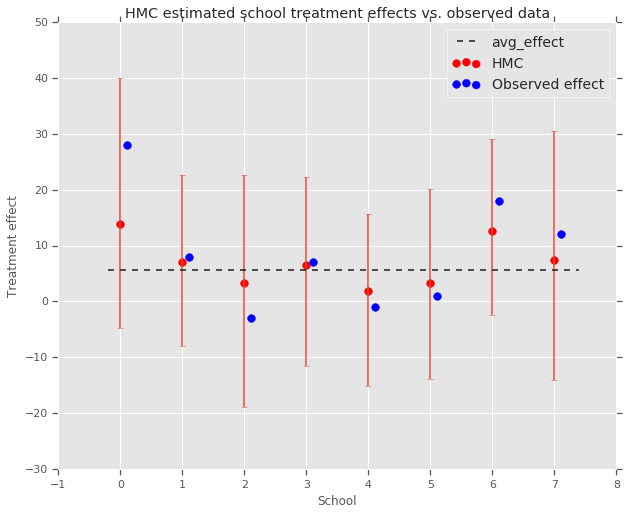

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
ax.scatter(np.array(range(num_schools)), school_effects_med, color='red', s=60)
ax.scatter(
    np.array(range(num_schools)) + 0.1, treatment_effects, color='blue', s=60)

plt.plot([-0.2, 7.4], [np.mean(avg_effect),
                       np.mean(avg_effect)], 'k', linestyle='--')

ax.errorbar(
    np.array(range(8)),
    school_effects_med,
    yerr=[
        school_effects_med - school_effects_low,
        school_effects_hi - school_effects_med
    ],
    fmt='none')

ax.legend(('avg_effect', 'HMC', 'Observed effect'), fontsize=14)

plt.xlabel('School')
plt.ylabel('Treatment effect')
plt.title('HMC estimated school treatment effects vs. observed data')
fig.set_size_inches(10, 8)
plt.show()

上記の集団 `avg_effect` への縮小が見られます。

In [ ]:
print("Inferred posterior mean: {0:.2f}".format(
    np.mean(school_effects_samples[:,])))
print("Inferred posterior mean se: {0:.2f}".format(
    np.std(school_effects_samples[:,])))

Inferred posterior mean: 6.97
Inferred posterior mean se: 10.41


# 批評

事後確率予測分布、つまり特定の観測データ $y$ である場合に新しいデータ $y^*$ のモデルを取得するには、次のようにします。

$$ p(y^*|y) \propto \int_\theta p(y^* | \theta)p(\theta |y)d\theta$$

モデルのランダム変数の値をオーバーライドして、事後確率分布の平均に設定し、そのモデルからサンプリングして新しいデータ $y^*$ を生成します。

In [ ]:
sample_shape = [5000]

_, _, _, predictive_treatment_effects = model.sample(
    value=(tf.broadcast_to(np.mean(avg_effect, 0), sample_shape),
           tf.broadcast_to(np.mean(avg_stddev, 0), sample_shape),
           tf.broadcast_to(np.mean(school_effects_standard, 0),
                           sample_shape + [num_schools]),
           None))

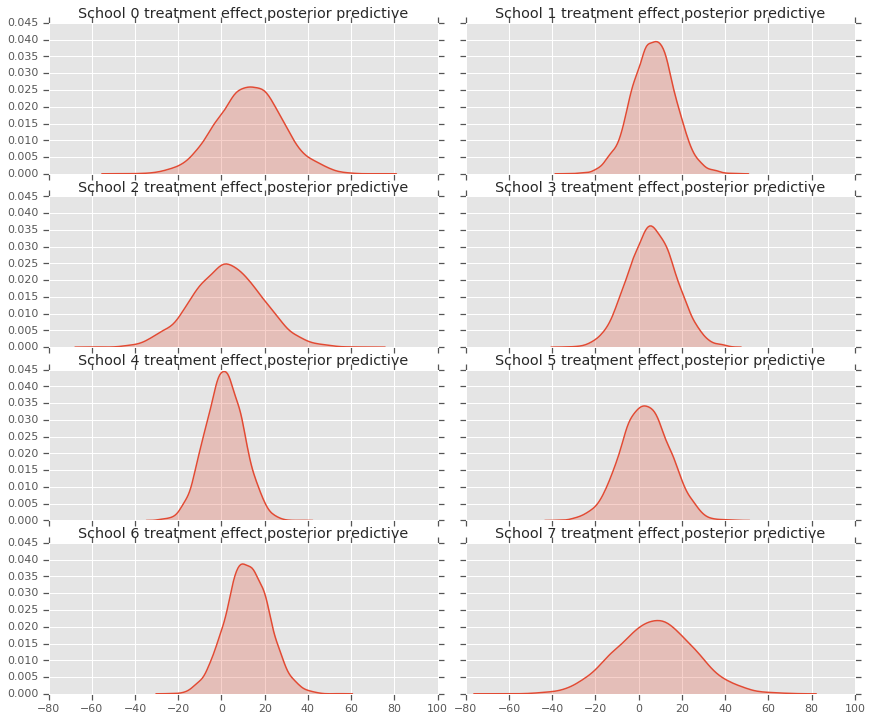

In [ ]:
fig, axes = plt.subplots(4, 2, sharex=True, sharey=True)
fig.set_size_inches(12, 10)
fig.tight_layout()
for i, ax in enumerate(axes):
  sns.kdeplot(predictive_treatment_effects[:, 2*i].numpy(),
              ax=ax[0], shade=True)
  ax[0].title.set_text(
      "School {} treatment effect posterior predictive".format(2*i))
  sns.kdeplot(predictive_treatment_effects[:, 2*i + 1].numpy(),
              ax=ax[1], shade=True)
  ax[1].title.set_text(
      "School {} treatment effect posterior predictive".format(2*i + 1))
plt.show()

In [ ]:
# The mean predicted treatment effects for each of the eight schools.
prediction = np.mean(predictive_treatment_effects, axis=0)

処置効果データとモデルの事後確率予測の間にある残差を見ることができます。これらは、母集団の平均に対する推定効果の縮小を示す上記のプロットに対応しています。

In [ ]:
treatment_effects - prediction

array([14.905351 ,  1.2838383, -5.6966295,  0.8327627, -2.3356671,
       -2.0363257,  5.997898 ,  4.3731265], dtype=float32)

各高校の予測の分布があるため、残差の分布も検討することができます。

In [ ]:
residuals = treatment_effects - predictive_treatment_effects

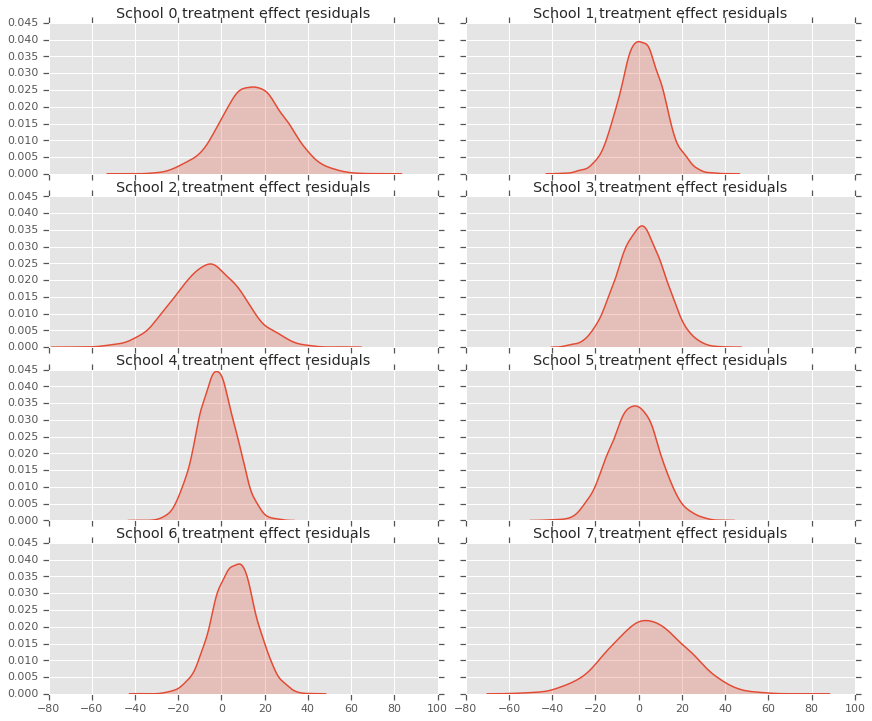

In [ ]:
fig, axes = plt.subplots(4, 2, sharex=True, sharey=True)
fig.set_size_inches(12, 10)
fig.tight_layout()
for i, ax in enumerate(axes):
  sns.kdeplot(residuals[:, 2*i].numpy(), ax=ax[0], shade=True)
  ax[0].title.set_text(
      "School {} treatment effect residuals".format(2*i))
  sns.kdeplot(residuals[:, 2*i + 1].numpy(), ax=ax[1], shade=True)
  ax[1].title.set_text(
      "School {} treatment effect residuals".format(2*i + 1))
plt.show()

# 謝辞

このチュートリアルは Edward 1.0（[出典](https://github.com/blei-lab/edward/blob/master/notebooks/eight_schools.ipynb)）に掲載されていたものです。そのバージョンの作成と改訂に貢献されたすべての方に感謝します。

# 参考資料

1. Donald B. Rubin. Estimation in parallel randomized experiments. Journal of Educational Statistics, 6(4):377-401, 1981.
2. Andrew Gelman, John Carlin, Hal Stern, David Dunson, Aki Vehtari, and Donald Rubin. Bayesian Data Analysis, Third Edition. Chapman and Hall/CRC, 2013.